In [8]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 

In [9]:
# cats vs dogs dataset 
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

## Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [12]:
import os 
from tqdm import tqdm 
num_skipped = 0 
for folder_name in ('Cat', 'Dog'): 
    folder_path = os.path.join('data/PetImages', folder_name)
    for fname in tqdm(os.listdir(folder_path)): 
        fpath = os.path.join(folder_path, fname) 
        try: 
            fobj = open(fpath, 'rb')
            is_jfif = tf.compat.as_bytes('JFIF') in fobj.peek(10)
        finally:
            fobj.close()
        
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
print(f'Deleted {num_skipped} images')

100%|██████████| 12501/12501 [01:07<00:00, 185.57it/s]

Deleted 1425 images


In [13]:
image_size = (180, 180)
batch_size = 32 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/PetImages', 
    validation_split=0.2, 
    subset='training', 
    seed=1337, 
    image_size=image_size, 
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/PetImages', 
    validation_split=0.2, 
    subset='validation', 
    seed=1337, 
    image_size=image_size, 
    batch_size=batch_size 
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


# Data Augmentation 

When the image dataset is not large, it is good practice to artifically introduce sample diversity by applying random yet ralistic transformations tothe traiining images such as random horizontal flipping or small random rotations. This helps to expose the model to different aspects of the training data while slowing down overfitting (note, the data augmented images form traning set will only be in the training set, same goes for the validation set)

In [14]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'), 
    layers.RandomRotation(0.1)
])

# Data Standardization 

(180x180) images of continuous float32 batches. RGB channels are from `[0,255]`. Should be tranformed to `[0,1]` by using a `Rescaling`. 

There are two options to preprocess the data. 

__Options 1: Make it part of the Model__: 
```
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
```
With this option, you data augmentatoin will happen on _device_ synchronously with the reso of model execution. Benefit from GPU acceleration. Data augmentation is inative at test time, so the input samples will only be augmented during `fit()`, not when calling `evaluate()` or `predict()`. 

__Option 2: apply it to the dataet__: will happen async on CPU. 

In [15]:
# Make sure to use buffered prefetch so data can be retrieved from disk without I/O becoming blocking 
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Build a model 
We'll build a small version of the Xception network. `KerasTuner` library can be used to optimize it. 

In [16]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # entry block 
    x = layers.Rescaling(1.0/255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x # set aside residual 

    for size in [128, 512, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPool2D(3, strides=2, padding='same')(x)

        # project residual 
        residual = layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x # set aside next residual 
    
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = 'sigmoid' 
        units = 1 
    else: 
        activation = 'softmax' 
        untis = num_classes
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

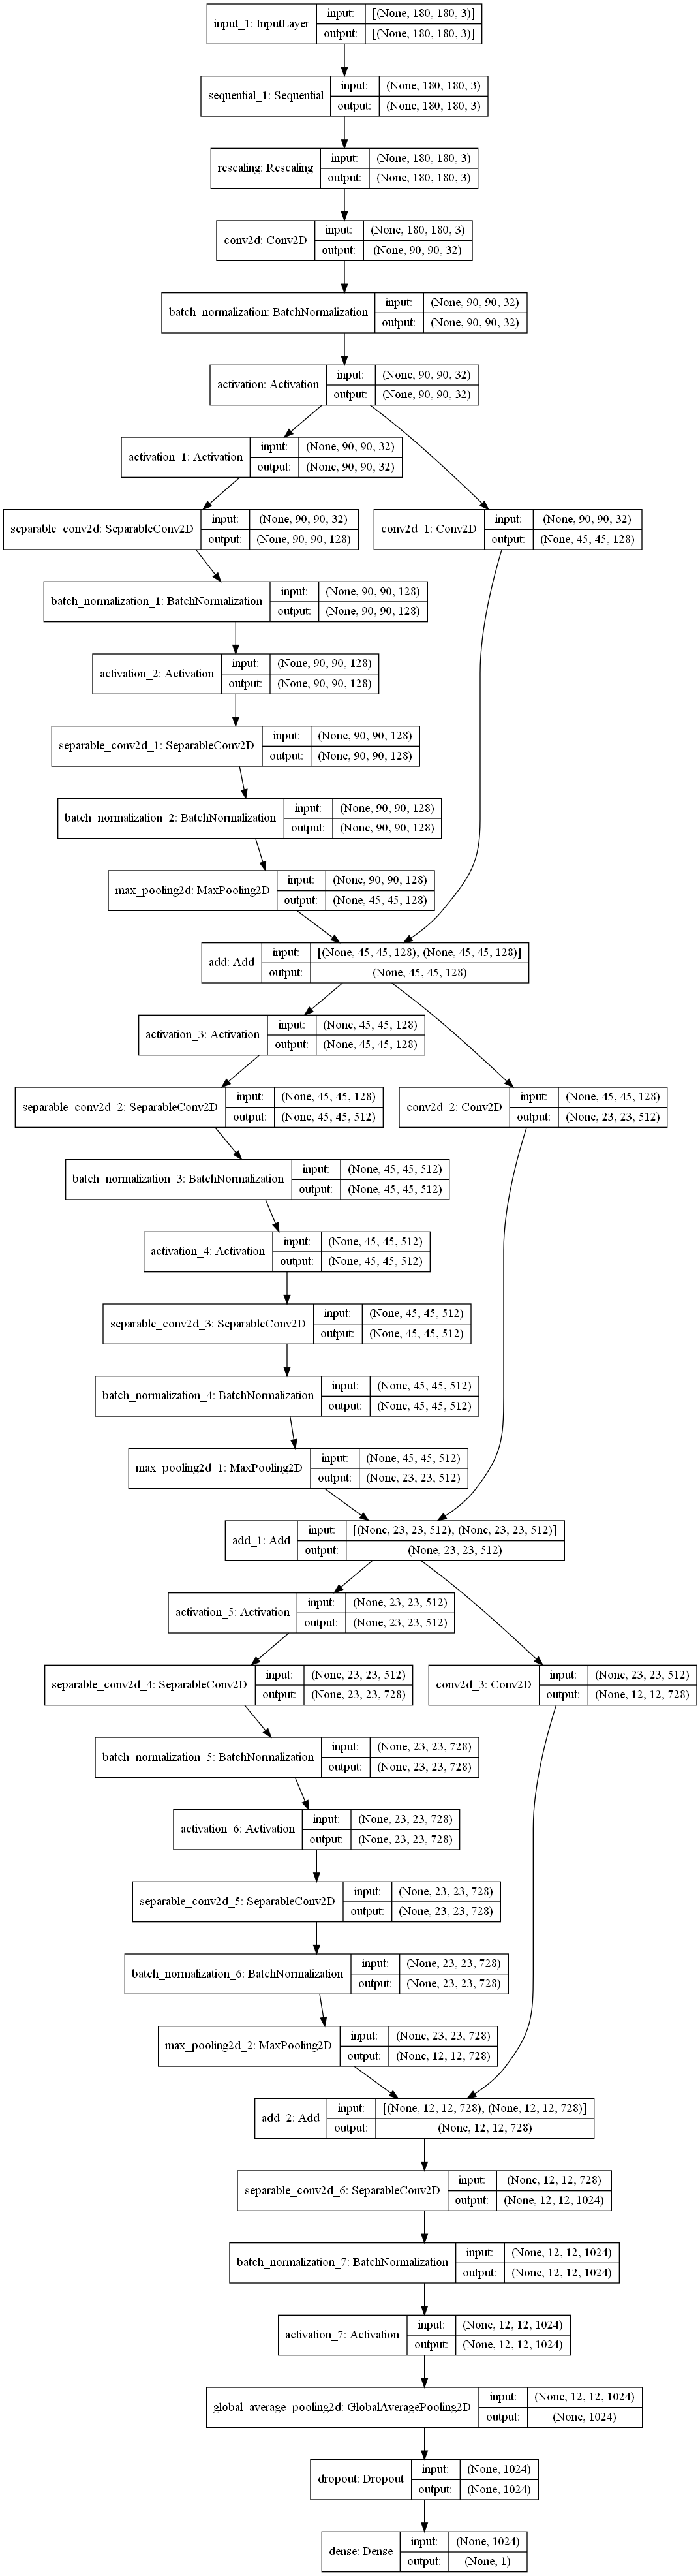

In [17]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [18]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint('save_at_{epoch}.h5'),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[32,512,45,45] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/separable_conv2d_3/separable_conv2d/depthwise (defined at C:\Users\fkhan\AppData\Local\Temp/ipykernel_13292/3240005834.py:11) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3701]

Function call stack:
train_function
